# Dataset

This dataset is about past loans. It includes details of 346 customers whose loan are already paid off or defaulted. Overview:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


## Train Dataset

In [49]:
#!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

## Test Dataset

In [50]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

In [3]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### Load Data From CSV File


In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object


In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [8]:
print('This data has {} paidoff observations and {} in collection'.format(df['loan_status'].value_counts().to_frame().iloc[0,0], df['loan_status'].value_counts().to_frame().iloc[1,0]))

This data has 260 paidoff observations and 86 in collection


In [9]:
df_gr = df['Gender'].value_counts().to_frame()
print('This data has {} men and {} women'.format(df_gr.iloc[0,0], df_gr.iloc[1,0]))

This data has 294 men and 52 women


In [51]:
#!conda install -c anaconda seaborn -y
import seaborn as sns

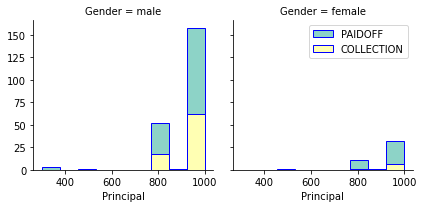

In [11]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="blue")

g.axes[-1].legend()
plt.show()

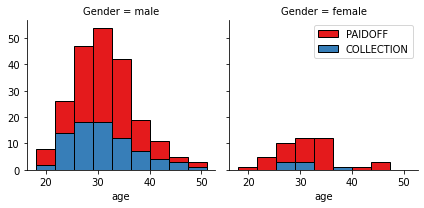

In [12]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


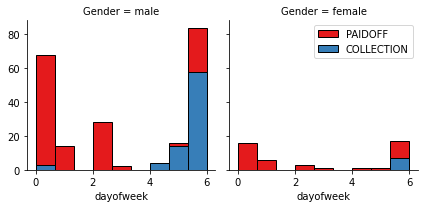

In [13]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

People who get the loan at the end of the week don't pay it off, so I will use Feature binarization to set a threshold value less than day 4

In [14]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Converting male to 0 and female to 1:

In [16]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Convererting categorical varables to binary variables and append them to the feature df

In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection

In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


## Normalize Data

In [21]:
x= preprocessing.StandardScaler().fit(X).transform(X)
x[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification

# K Nearest Neighbor(KNN)

In [22]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
y = np.asarray(df['loan_status'])
y[0:5]

array([0, 0, 0, 0, 0])

In [23]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [25]:
y_test[0:3]

array([0, 0, 0])

[0.67142857 0.77142857 0.71428571 0.77142857 0.75714286 0.78571429
 0.78571429 0.77142857 0.75714286 0.75714286 0.7        0.68571429
 0.7        0.68571429]


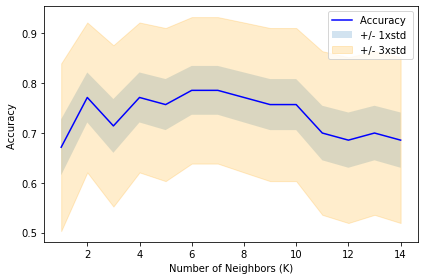

The best accuracy was with 0.7857 with k= 6


In [26]:
K = 15
mean = np.zeros((K-1))
std = np.zeros((K-1))
for n in range(1,K):  
    knn = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat_knn =knn.predict(x_test)
    mean[n-1] = metrics.accuracy_score(y_test, yhat_knn)   #test accuracy of index 9,8,7...0   
    std[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])   #std of index 9,8,7...0 pra margem de erro do grafico
print(mean)

plt.plot(range(1,K),mean,'blue')
plt.fill_between(range(1,K),mean - 1 * std, mean + 1 * std, alpha=0.2)
plt.fill_between(range(1,K),mean - 3 * std, mean + 3 * std, alpha=0.2, color="orange")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean.max().round(4), "with k=", mean.argmax()+1)

# Decision Tree


In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dt.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

# Support Vector Machine


In [29]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

In [30]:
from sklearn import svm
svm = svm.SVC(kernel='poly')
svm.fit(x_train, y_train)

SVC(kernel='poly')

In [31]:
yhat_svm = svm.predict(x_test)
yhat_svm

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

              precision    recall  f1-score   support

           0       0.79      0.96      0.87        55
           1       0.33      0.07      0.11        15

    accuracy                           0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Confusion matrix, without normalization
[[53  2]
 [14  1]]
Model F1 score is 0.7064793130366899
Jaccard score for Collection is 0.058823529411764705
Jaccard score for Paidoff is 0.7681159420289855


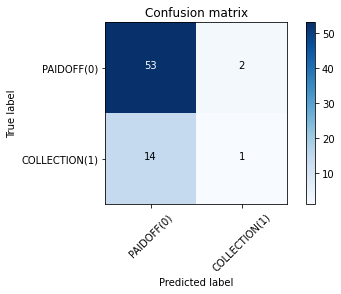

In [32]:
#Testing the evaluation metrics in this training data
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
confusionmatrix = confusion_matrix(y_test, yhat_svm, labels=[0,1]) #y labels are 0 and 1
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat_svm))
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(confusionmatrix, classes=['PAIDOFF(0)','COLLECTION(1)'],normalize= False,  title='Confusion matrix')

print('Model F1 score is {}'.format(f1_score(y_test, yhat_svm, average='weighted')))
print('Jaccard score for Collection is {}'.format(jaccard_score(y_test, yhat_svm, pos_label=1)))
print('Jaccard score for Paidoff is {}'.format(jaccard_score(y_test, yhat_svm, pos_label=0)))

# Logistic Regression


In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)
#Testing model on this training dataset
yhat_lr = LR.predict(x_test)
yhat_prob = LR.predict_proba(x_test)

In [35]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_lr,pos_label=0)

0.6764705882352942

Confusion matrix, without normalization
[[ 2 13]
 [ 9 46]]


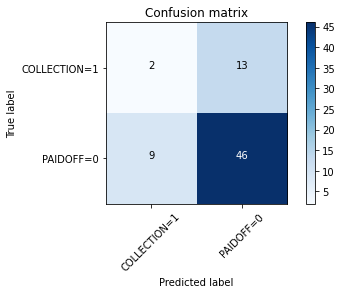

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_lr, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION=1','PAIDOFF=0'],normalize= False,  title='Confusion matrix')

In [37]:
print (classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81        55
           1       0.18      0.13      0.15        15

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.65      0.69      0.67        70



In [38]:
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.5772287609479654

# Model Evaluation using Test set


In [39]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

### Load Test set for evaluation


In [40]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [41]:
test_df.shape

(54, 10)

In [42]:
#Defining x_test
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2, pd.get_dummies(test_df['education'])], axis=1)
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
x_test1 = Feature2
x_test1 = preprocessing.StandardScaler().fit(x_test1).transform(x_test1)
x_test1.shape

(54, 8)

In [43]:
#Defining y_test
y_test1 = np.asarray(test_df['loan_status'])
y_test1.shape

(54,)

In [44]:
#KNN
yhat_knn1 =knn.predict(x_test1)
print('KNN jaccard score is {}'.format(jaccard_score(y_test1, yhat_knn1)))
print('KNN F1 score is {}'.format(f1_score(y_test1, yhat_knn1, average='weighted')))

KNN jaccard score is 0.1111111111111111
KNN F1 score is 0.6579124579124579


In [45]:
#Decision Tree
yhat_dt1 = dt.predict(x_test1)
print('Decision Tree jaccard score is {}'.format(jaccard_score(y_test1, yhat_dt1)))
print('Decision Tree F1 score is {}'.format(f1_score(y_test1, yhat_dt1, average='weighted')))

Decision Tree jaccard score is 0.07142857142857142
Decision Tree F1 score is 0.6717642373556352


In [46]:
#SVM
yhat_svm1 = svm.predict(x_test1)
print('SVM jaccard score is {}'.format(jaccard_score(y_test1, yhat_svm1)))
print('SVM F1 score is {}'.format(f1_score(y_test1, yhat_svm1, average='weighted')))

SVM jaccard score is 0.13333333333333333
SVM F1 score is 0.6959228135698723


In [47]:
#Logist Regression
yhat_lr1 = LR.predict(x_test1)
yhat_prob1 = LR.predict_proba(x_test1)
print('Logist Regression jaccard score is {}'.format(jaccard_score(y_test1, yhat_lr1)))
print('Logist Regression LogLoss score is {}'.format(log_loss(y_test1, yhat_prob1)))
print('Logist Regression F1 score is {}'.format(f1_score(y_test1, yhat_lr1, average='weighted')))

Logist Regression jaccard score is 0.06666666666666667
Logist Regression LogLoss score is 0.5672153379912981
Logist Regression F1 score is 0.6604267310789049


In [48]:
eval = {'Algorithm': ['KNN','Decision Tree','SVM','LogisticRegression'],
        'Jaccard': [jaccard_score(y_test1, yhat_knn1),
                    jaccard_score(y_test1, yhat_dt1),
                    jaccard_score(y_test1, yhat_svm1),
                    jaccard_score(y_test1, yhat_lr1)],
        'F1-score':[f1_score(y_test1, yhat_knn1, average='weighted'),
                    f1_score(y_test1, yhat_dt1, average='weighted'),
                    f1_score(y_test1, yhat_svm1, average='weighted'),
                    f1_score(y_test1, yhat_lr1, average='weighted')],
        'LogLoss':['N/A','N/A','N/A', log_loss(y_test1, yhat_prob1)]
        }

metrics = pd.DataFrame(eval, columns = ['Algorithm', 'Jaccard','F1-score', 'LogLoss'])
metrics.style.hide_index()

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.111111,0.657912,N/A
Decision Tree,0.071429,0.671764,N/A
SVM,0.133333,0.695923,N/A
LogisticRegression,0.066667,0.660427,0.567215


## From the metrics table above, SVM seems to be the best predictive model.